In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from extract_transform import get_match

In [3]:
# TODO - add docstrings, maybe move functions to modules
def llf(leaf_id): # leaf label func for dendrogram adapted from scipy docs
    """Map leaf_id (index) to Wikidata name
    
    leaf_id (int):
    
    """
    return wikidata.loc[leaf_id, 'name']

# map names based on whether their wikidata desc contains 'chain' and 'restaurant'
def get_color(ylabel): 
    try:
        color = color_dict[ylabel.get_text()]
    except:
        color = 'b'
    return color

In [5]:
raw_wikidata = pd.read_json('data/wikidata.json')
preprocessed_wikidata = pd.read_json('data/preprocessed-wikidata.json')
wikidata = raw_wikidata.merge(preprocessed_wikidata, on='qid')

In [4]:
wikidata['name'] = wikidata['names'].apply(lambda names: names[0])
descriptions = wikidata['preprocessed_description']

In [ ]:
# the approach: identify chain restaurants by identifying Wikidata entries about chain 
# restaurants and mapping it back to the OSM data 

In [5]:
contains_chain = wikidata['preprocessed_description'].apply(
    lambda description: get_match('chain', description)
).notna()

contains_restaurant = wikidata['preprocessed_description'].apply(
    lambda description: get_match('restaurant', description)
).notna()
contains_chain_and_restaurant = (contains_chain & contains_restaurant)
# -> regex approach, pretty sure descriptions that contain the words 'chain' and 'restaurant'
# represent chain restaurants, more false negatives (not all descriptions for chain 
# restaurants contain both the words 'chain' and 'restaurant')

In [6]:
# color names associated with wikidata descriptions that contain 'chain' and 'restaurant' red
# -> compare regex predictions with cosine similarity clusters
color_dict = {}
for name in wikidata.loc[contains_chain_and_restaurant, 'name'].values:
    color_dict[name] = 'r'

In [7]:
vectorizer = CountVectorizer(lowercase=False)
document_term_matrix = vectorizer.fit_transform(descriptions)
cosine_similarities = cosine_similarity(document_term_matrix)

In [13]:
osm_data

,lat,lon,timestamp,amenity,name,tags,cuisine,qid
0,49.260812,-123.125736,2020-03-20T18:22:12.000-07:00,cafe,Starbucks,"{'brand:wikidata': 'Q37158', 'official_name': ...",coffee_shop,Q37158
1,49.260953,-123.125704,2019-08-02T18:11:20.000-07:00,fast_food,Salad Loop,{'opening_hours': 'Mo-Fr 07:00-17:00; Sa 10:00...,None,None
2,49.373423,-123.291894,2016-10-10T02:14:29.000-07:00,toilets,None,{},None,None
3,49.249848,-122.959708,2011-09-06T03:52:10.000-07:00,bbq,None,{},None,None
4,49.370898,-123.280448,2015-05-03T00:42:25.000-07:00,place_of_worship,St. Monica's Anglican Church,"{'addr:housenumber': '6404', 'addr:street': 'W...",None,None
...,...,...,...,...,...,...,...,...
17713,49.278424,-122.806704,2013-03-26T23:45:49.000-07:00,cafe,Creekside Coffee,{},None,None
17714,49.278770,-122.797628,2013-03-26T23:45:49.000-07:00,restaurant,Togo Sushi,{'cuisine': 'japanese'},japanese,None
17715,49.276443,-122.790138,2013-03-26T23:45:50.000-07:00,parking,None,{},None,None
17716,49.282666,-122.826978,2019-09-13T13:56:49.000-07:00,pub,Brown's Social House,"{'addr:housenumber': '215', 'brewery': 'Guinne...",None,None


In [12]:
wikidata

,qid,names,description,preprocessed_names,preprocessed_description
0,Q37158,"[Starbucks, Starbucks Corporation, Starbucks C...",American multinational coffee company,starbucks starbucks corporation starbucks coff...,american multinational coffee company
1,Q154950,"[Royal Dutch Shell, RDS, Shell, Royal Dutch Sh...",Anglo-Dutch oil company,royal dutch shell rds shell royal dutch shell plc,anglo dutch oil company
2,Q1543874,"[The Hertz Corporation, Hertz Rental Car, Hert...",Car rental,hertz corporation hertz rental car hertz rent car,car rental
3,Q1208279,[Petro-Canada],company,petro canada,company
4,Q867662,"[Esso, Exxcon]",oil and gas company,esso exxcon,oil gas company
...,...,...,...,...,...
108,Q862180,[Second Cup],Canadian coffee roaster and retailer,second cup,canadian coffee roaster retailer
109,Q8054358,[Yogen Früz],Canadian multinational frozen yogurt and smoot...,yogen früz,canadian multinational frozen yogurt smoothy r...
110,Q7702453,[Teriyaki Experience],,teriyaki experience,
111,Q64876684,[Kernels Popcorn],Canadian popcorn retailer,kernel popcorn,canadian popcorn retailer


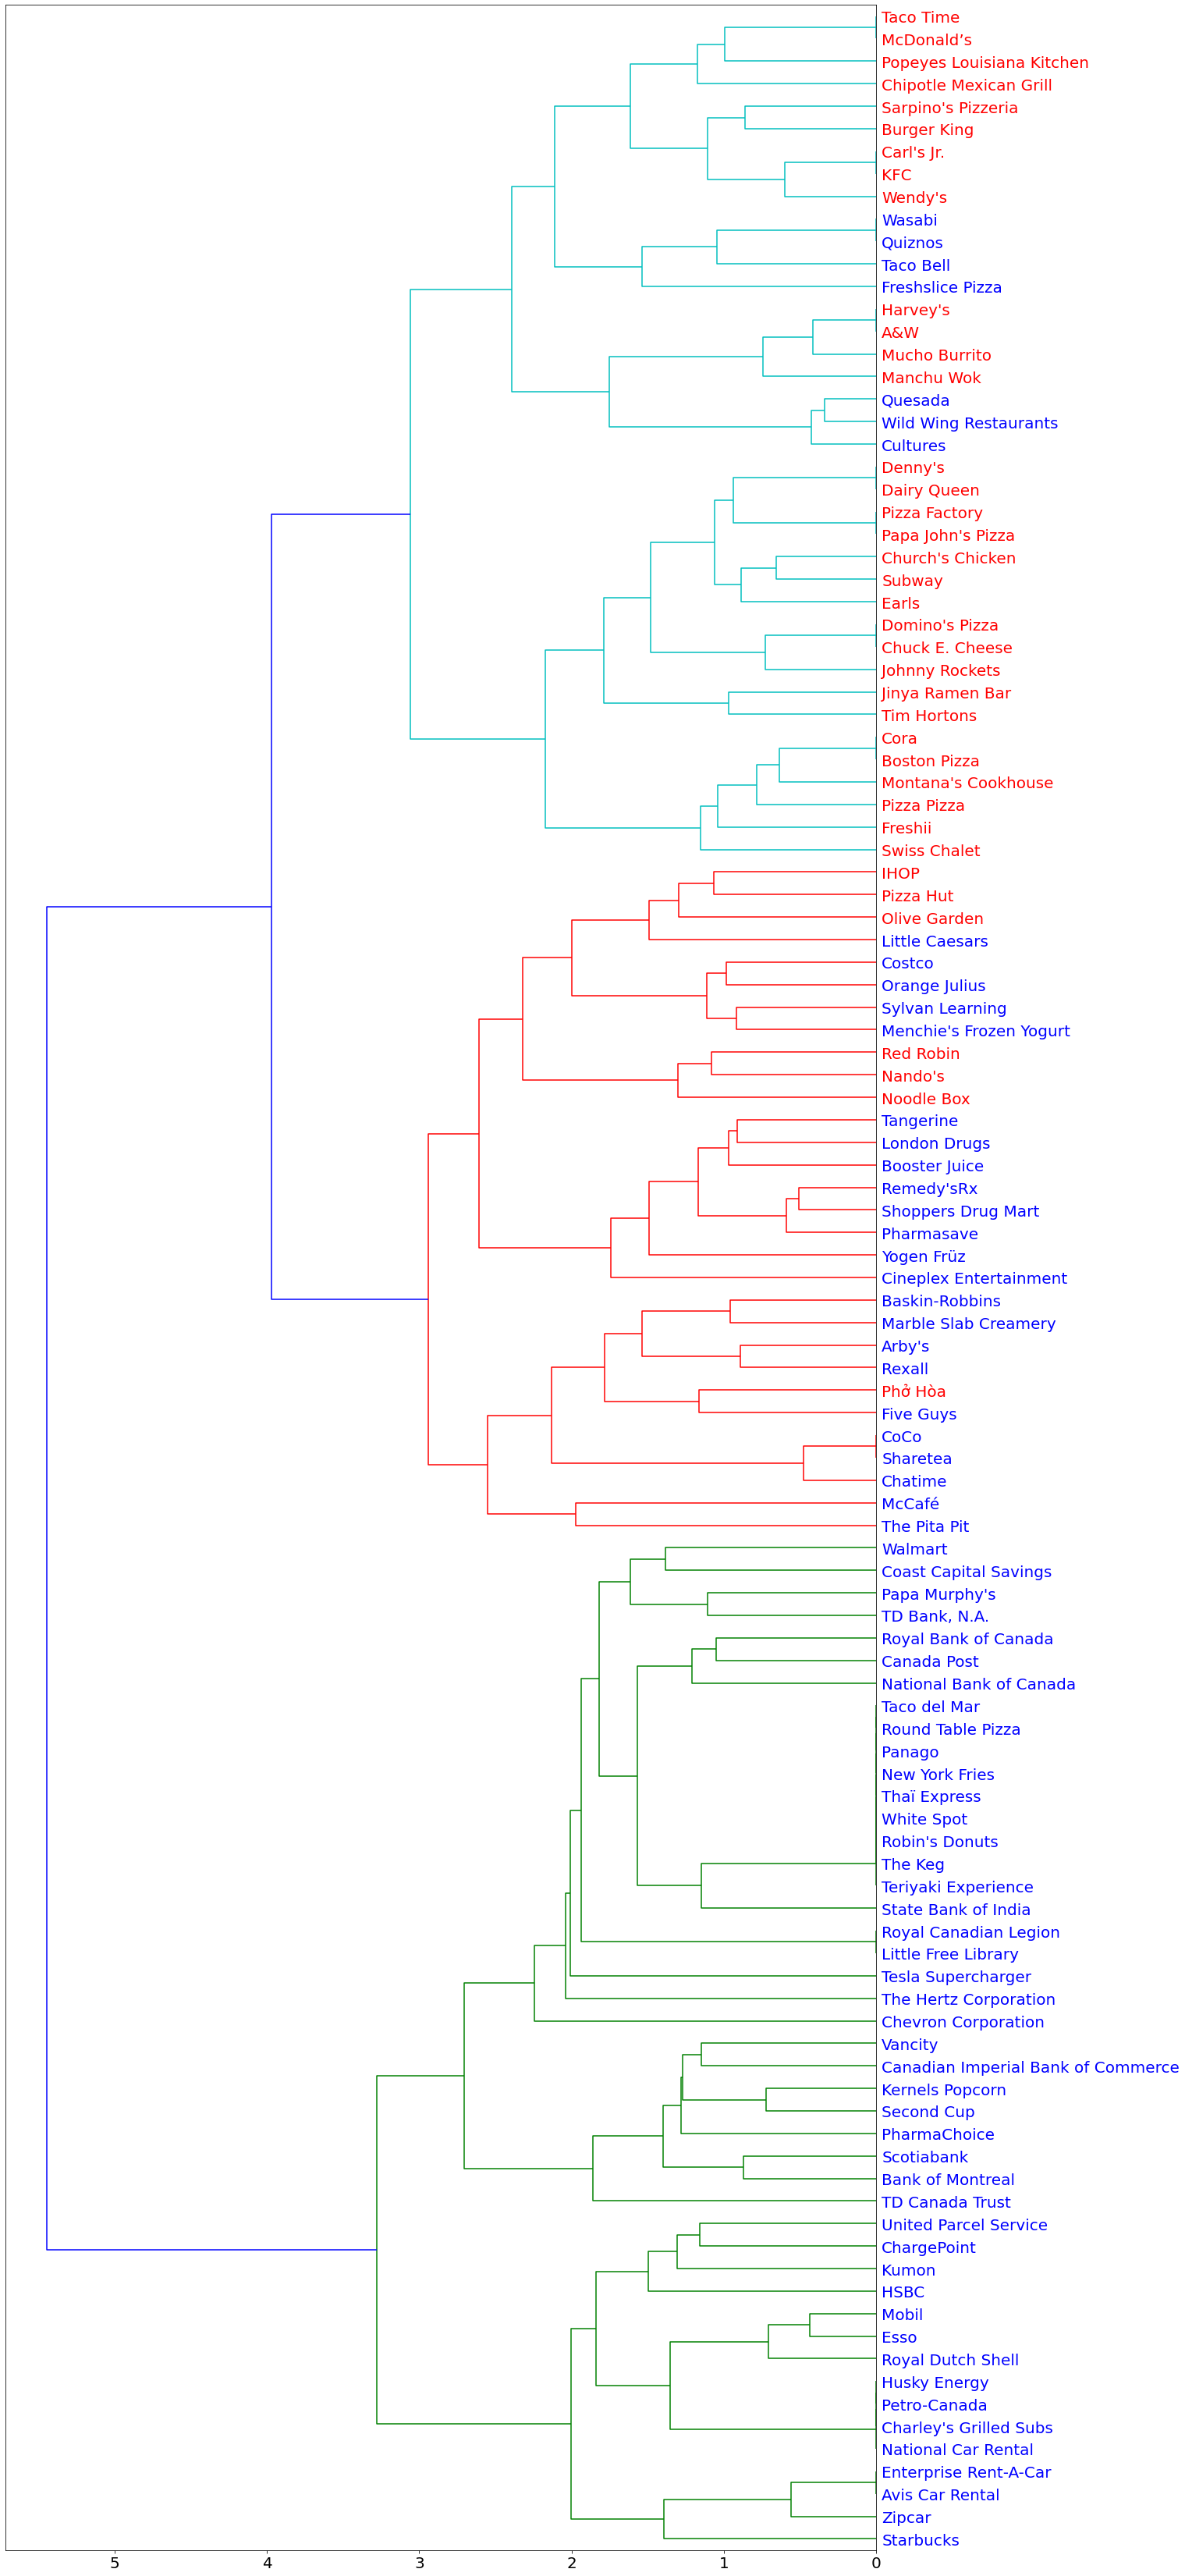

In [9]:
# scipy dendrogram docs
Z = linkage(cosine_similarities, method='complete')

# LOOKS UGLY ON GITLAB USE https://kokes.github.io/nbviewer.js/viewer.html
fig = plt.figure(figsize=(20, 60)) 
dn = dendrogram(Z, leaf_label_func=llf, orientation='left', leaf_font_size=20)

# label coloring adapted from Warren Weckesser's answer at 
# https://stackoverflow.com/questions/14802048/
ax = plt.gca()
ylabels = ax.get_ymajorticklabels()
for ylabel in ylabels:
    ylabel.set_color(get_color(ylabel))
    
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [37]:
cluster_labels = fcluster(Z, t=4, criterion='maxclust')

In [46]:
pnames = llf(wikidata.index) # get names given index 

In [47]:
dict(zip(pnames, cluster_labels)) # dict name and cluster label

{'Starbucks': 1,
 'Royal Dutch Shell': 1,
 'The Hertz Corporation': 2,
 'Petro-Canada': 1,
 'Esso': 1,
 'Tim Hortons': 4,
 'Pharmasave': 3,
 'Canada Post': 2,
 'Chevron Corporation': 2,
 'London Drugs': 3,
 "Nando's": 3,
 'Boston Pizza': 4,
 'McDonald’s': 4,
 'Canadian Imperial Bank of Commerce': 2,
 'Subway': 4,
 'KFC': 4,
 'Burger King': 4,
 'Little Free Library': 2,
 'Husky Energy': 1,
 'Bank of Montreal': 2,
 'Vancity': 2,
 'Cora': 4,
 'Chatime': 3,
 'The Pita Pit': 3,
 'Rexall': 3,
 'A&W': 4,
 'Round Table Pizza': 2,
 'Taco del Mar': 2,
 'Pizza Hut': 3,
 "Montana's Cookhouse": 4,
 'Swiss Chalet': 4,
 'Royal Bank of Canada': 2,
 'Mucho Burrito': 4,
 'Shoppers Drug Mart': 3,
 'Five Guys': 3,
 'Dairy Queen': 4,
 'Quiznos': 4,
 'Panago': 2,
 'Booster Juice': 3,
 'Freshslice Pizza': 4,
 'New York Fries': 2,
 'Manchu Wok': 4,
 'Thaï Express': 2,
 'Chuck E. Cheese': 4,
 'Scotiabank': 2,
 "Papa John's Pizza": 4,
 "Domino's Pizza": 4,
 'TD Canada Trust': 2,
 'HSBC': 1,
 'McCafé': 3,
 'Oran

In [ ]:
# groupby cluster number, find max freq contains_chain_and_restaurant return cluster number

In [ ]:
# cluster actually groups some chain restaurants with descriptions that do not contain the words
# 'chain' or 'restaurant'